In [1]:
import os, sys
if os.path.exists("./src"):
    directory_to_prepend = os.path.abspath("./src")
else:
    raise RuntimeError("'src' is not in path")

print(f"-> src path found in: '{directory_to_prepend}")

if directory_to_prepend not in sys.path:
    sys.path = [directory_to_prepend] + sys.path

-> src path found in: '/home/gergedan/academy/shnn-repo/src


In [2]:
# system libs
import os; from time import time; from typing import Any

# data
import numpy as np
from data import get_train_test_set

# logger, model saving
from joblib import dump
from experiment import SampledDomainParams, SampledModelParams, SampledExperiment, SampledModelResults, SampledModels
from hamiltonian.single_pendulum import SinglePendulum

# argument parser
from argparser import sampled_hnn_experiment_argparser

# sampling params
from model.s_hnn import S_HNN
from activation.type import ActivationType
from model.sampled_network_type import SampledNetworkType
from trainer.param_sampler import ParameterSampler
from trainer.sampler import Sampler

# does not have any affect on sampling, only for traditional hnn
from util.device_type import DeviceType

# evaluation method
from error.l2 import l2_error_rel

# EXPERIMENT PARAMS
save_dir = "./experiments"
repeat = 10

# DOMAIN PARAMS
START_DATA_RANDOM_SEED = 3943
single_pendulum = SinglePendulum(m=1., l=1., g=1., f=1.)
q_lims = [ [-np.pi, np.pi] ]
p_lims = [ [-1., 1.] ]
min_input = np.min([q_lims, p_lims])
max_input = np.max([q_lims, p_lims])
train_size = 2500
test_size = 2500
domain_params = SampledDomainParams(
    single_pendulum, q_lims, p_lims, 
    train_size, test_size,
    repeat, START_DATA_RANDOM_SEED
)

# MODEL PARAMS
START_MODEL_RANDOM_SEED = 992472
activation = ActivationType.TANH
rcond = 1e-13
network_width = 200
model_params = SampledModelParams(
    activation, network_width, 
    resample_duplicates=True, rcond=rcond,
    elm_bias_start=min_input, elm_bias_end=max_input,
    start_model_random_seed=START_MODEL_RANDOM_SEED
)

# Error correction demonstration using time series data only (q,p) without the knowledge of gradients or vector fields

See: https://arxiv.org/abs/2106.11753 for the error correction introduced for traditional neural networks

See: https://arxiv.org/abs/2108.02492 for the integration of the error correction into the linear system similar to the one used here

In [3]:
experiment_models = {}
experiment_errors = {}
experiment_corrected_errors = {}

for dt_obs in [0.05, 0.1, 0.2, 0.4, 0.8]:
    print(f"-> running with dt_obs={dt_obs}")
    START_MODEL_RANDOM_SEED = model_params.start_model_random_seed
    START_DATA_RANDOM_SEED = domain_params.start_data_random_seed

    # we only experiment with A-SWIM here, the used model is not really important for 
    # demonstrating the error correction
    aswim_models = []; aswim_test_errors = []; aswim_corrected_test_errors = [];

    MODEL_RANDOM_SEED = START_MODEL_RANDOM_SEED
    DATA_RANDOM_SEED = START_DATA_RANDOM_SEED
    for run_index in range(domain_params.repeat):
        train_set, test_set = get_train_test_set(1, single_pendulum, domain_params.train_size, domain_params.test_size, domain_params.q_lims, domain_params.p_lims, rng=np.random.default_rng(DATA_RANDOM_SEED), use_fd=True, dt_obs=dt_obs)
        
        ( ((train_inputs, train_inputs_next), train_dt_truths, train_H_truths, train_H_grad_truths), (train_x_0, train_x_0_H_truth) ) = train_set
        ( test_inputs, test_dt_truths, test_H_truths, test_H_grad_truths ) = test_set

        model = S_HNN(input_dim=2, hidden_dim=model_params.network_width, activation=ActivationType.TANH, resample_duplicates=model_params.resample_duplicates, rcond=model_params.rcond, random_seed=MODEL_RANDOM_SEED, elm_bias_start=model_params.elm_bias_start, elm_bias_end=model_params.elm_bias_end)
        sampler = Sampler(SampledNetworkType.A_SWIM, ParameterSampler.TANH)

        # use symplectic euler integration in the approximation scheme
        train_inputs_next_q, _ = np.split(train_inputs_next, 2, axis=1)
        _, train_inputs_p = np.split(train_inputs, 2, axis=1)
        sampler.train(model, np.hstack((train_inputs_next_q, train_inputs_p)), train_dt_truths, train_x_0, train_x_0_H_truth, DeviceType.CPU)

        aswim_models.append(model)

        test_H_preds = model.H(test_inputs)
        error = l2_error_rel(test_H_truths, test_H_preds)
        aswim_test_errors.append(error)

        # calculate the first-order correction to the Hamiltonian for the symplectic euler scheme
        # The einsum realizes a dot product between dH_q and dH_p
        test_H_grad_preds = model.H_grad(test_inputs)
        test_H_grad_preds_q_part, test_H_grad_preds_p_part = np.split(test_H_grad_preds, 2, axis=1)
        test_H_preds = test_H_preds + (dt_obs/2) * np.einsum("ij,ij->i", test_H_grad_preds_q_part, test_H_grad_preds_p_part).reshape(-1, 1)
        error = l2_error_rel(test_H_truths, test_H_preds)
        aswim_corrected_test_errors.append(error)    

    experiment_models[str(dt_obs)] = aswim_models
    experiment_errors[str(dt_obs)] = aswim_test_errors
    experiment_corrected_errors[str(dt_obs)] = aswim_corrected_test_errors

    mean_error = np.mean(aswim_test_errors)
    corrected_mean_error = np.mean(aswim_corrected_test_errors)
    print(f"mean error:              {mean_error : .2E}")
    print(f"corrected mean error:    {corrected_mean_error : .2E}")
    print()

# save models and results
dump(experiment_models, os.path.join(save_dir, "error_correction_experiment_models.pkl"))
dump(experiment_errors, os.path.join(save_dir, "error_correction_experiment_uncorrected_errors.pkl"))
dump(experiment_corrected_errors, os.path.join(save_dir, "error_correction_experiment_corrected_errors.pkl"))

-> running with dt_obs=0.05
mean error:               7.42E-03
corrected mean error:     1.04E-04

-> running with dt_obs=0.1
mean error:               1.49E-02
corrected mean error:     4.17E-04

-> running with dt_obs=0.2
mean error:               2.99E-02
corrected mean error:     1.68E-03

-> running with dt_obs=0.4
mean error:               6.07E-02
corrected mean error:     6.90E-03

-> running with dt_obs=0.8
mean error:               1.27E-01
corrected mean error:     3.00E-02



['./experiments/error_correction_experiment_corrected_errors.pkl']

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# Configure MPL parameters (taken from https://github.com/jbmouret/matplotlib_for_papers)
golden_ratio = (5**.5 - 1) / 2
params = {
    'figure.figsize': [5, 5*golden_ratio],
    "text.usetex": True,
    "font.family": "serif",
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "font.size": 12,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
}
mpl.rcParams.update(params)

%matplotlib inline

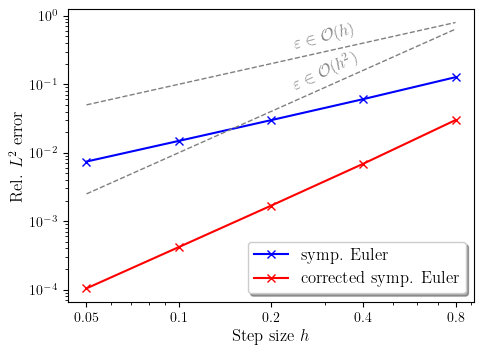

In [5]:
# plot uncorrected and corrected model errors (mean values)
fig, ((ax)) = plt.subplots(1, 1, figsize=(5,6*golden_ratio), dpi=100)
dt_list = np.array([0.05, 0.1, 0.2, 0.4, 0.8])

mean_errors = []
min_errors = []
max_errors = []

mean_corrected_errors = []
min_corrected_errors = []
max_corrected_errors = []

for dt in dt_list:
    mean_errors.append(np.mean(experiment_errors[str(dt)]))
    min_errors.append(np.min(experiment_errors[str(dt)]))
    max_errors.append(np.max(experiment_errors[str(dt)]))
    
    mean_corrected_errors.append(np.mean(experiment_corrected_errors[str(dt)]))
    min_corrected_errors.append(np.min(experiment_corrected_errors[str(dt)]))
    max_corrected_errors.append(np.max(experiment_corrected_errors[str(dt)]))

ax.loglog(dt_list, mean_errors, "x-", c="blue")
ax.loglog(dt_list, mean_corrected_errors, "x-", c="red")
ax.fill_between(np.log10(dt_list), np.log10(min_errors), np.log10(max_errors), color="blue", alpha=0.2)
ax.fill_between(np.log10(dt_list), np.log10(min_corrected_errors), np.log10(max_corrected_errors), color="red", alpha=0.2)

# reference lines
ax.loglog(dt_list, dt_list, '--', color="grey", linewidth=1)
ax.text(0.3, 0.3-0.01, r'$\varepsilon \in \mathcal{O}(h)$',
        color='grey', rotation=15, verticalalignment='bottom', horizontalalignment='center')

ax.loglog(dt_list, dt_list**2, '--', color="grey", linewidth=1)
ax.text(0.3, 0.3**2-0.015, r'$\varepsilon \in \mathcal{O}(h^2)$',
        color='grey', rotation=25, verticalalignment='bottom', horizontalalignment='center')


ax.set_xticks(dt_list)
ax.set_xticklabels(map(str, dt_list))




ax.legend(['symp. Euler', 'corrected symp. Euler'], fontsize='medium', shadow=True, loc='best')
ax.set_xlabel(r'Step size $h$')
ax.set_ylabel(r'Rel. $L^2$ error')

fig.tight_layout()
fig.savefig("plots/error-correction.pdf")